# Training

## Imports

In [1]:
import sys
sys.path.append("/usr/local/lib/python3.8/dist-packages/")
sys.path.append("../")

from tqdm.notebook import tqdm
from torch.optim import AdamW
from torch.utils.data import DataLoader
from utils import plot_loss_history, plot_render_heatmap_prediction

import numpy as np
import os
import snook.data as sd
import snook.model as sm
import torch

## Generation

In [2]:
COLORS = sd.COLORS
BALLS  = [f"../resources/fbx/ball_{color}.fbx" for color in COLORS]
CUE    = "../resources/fbx/cue.fbx"
POOL   = "../resources/fbx/pool.fbx"
HDRI   = "../resources/hdri"
scene  = None

In [3]:
def generate(name: str, path: str, samples: int) -> None:
    if os.path.isdir(path):
        return
    
    if scene is None:
        scene = sd.Scene(
            sd.cFiles(BALLS, CUE, POOL, HDRI),
            sd.cTable((2.07793, 1.03677), (0.25, 0.20), 1.70342),
            sd.cDistances(0.1, 1.5, (10.0, 20.0)),
        )
    
    renders = os.path.join(path, "renders")
    data = os.path.join(path, "data")
    
    os.makedirs(renders, exist_ok=True)
    os.makedirs(data, exist_ok=True)
    
    for i in tqdm(range(samples), desc=name):
        scene.sample()
        scene.render(f"{renders}/{i}.png")
        scene.register(f"{data}/{i}.txt")

In [4]:
generate("Train", "dataset/train", 800)
generate("Valid", "dataset/valid", 100)
generate("Test",  "dataset/test",  100)

## Data Loaders

In [5]:
train        = sd.ReMaHeDataset("dataset/train/renders", "dataset/train/data", spread=4.0)
train_loader = DataLoader(train, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

valid        = sd.ReMaHeDataset("dataset/valid/renders", "dataset/valid/data", spread=4.0)
valid_loader = DataLoader(valid, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

test         = sd.ReMaHeDataset("dataset/test/renders", "dataset/test/data", spread=4.0)
test_loader  = DataLoader(test, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

## Model Training

In [6]:
EPOCHS = 50
REFINE = 5
SPREAD = 1000, 16

In [7]:
layers    = [sm.Layer(16, 24, 1), sm.Layer(24, 32, 6), sm.Layer(32, 64, 6)]
model     = sm.AutoEncoder(layers, 3, 1, scale=0.4).cuda()
criterion = sm.AdaptiveWingLoss().cuda()
optim     = AdamW(model.parameters())

In [8]:
def plot_example(dataset: sd.ReMaHeDataset) -> None:
    render, _, heatmap = dataset[0]
    prediction = torch.clamp(model(render.unsqueeze(0).cuda())[0, 0], 0, 1)
    plot_render_heatmap_prediction(render, heatmap, prediction)

In [9]:
def step(name: str, loader: DataLoader, spread: float, is_train: bool = True) -> float:
    global model
    model = model.train() if is_train else model.eval()
    total_loss = 0.0
    pbar = tqdm(loader, name)
    for render, mask, heatmap in pbar:
        render, mask, heatmap = render.cuda(), mask.cuda(), heatmap.cuda()
        if is_train:
            optim.zero_grad()
        loss = criterion(model(render).squeeze(1), heatmap)
        if is_train:
            loss.backward()
            optim.step()
        total_loss += loss.item()
        pbar.set_postfix(loss=total_loss / len(loader), spread=spread)
    return total_loss / len(loader)

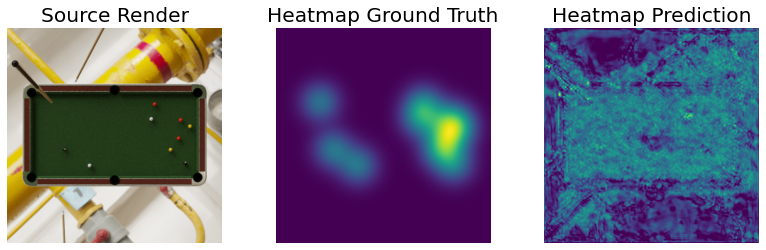

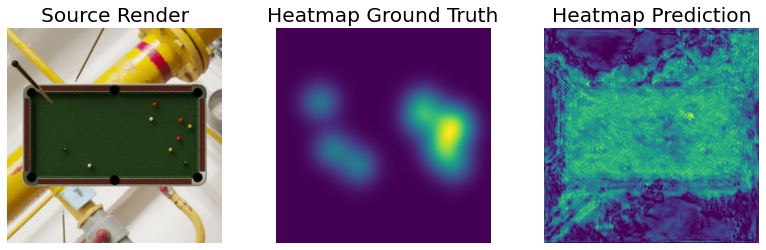

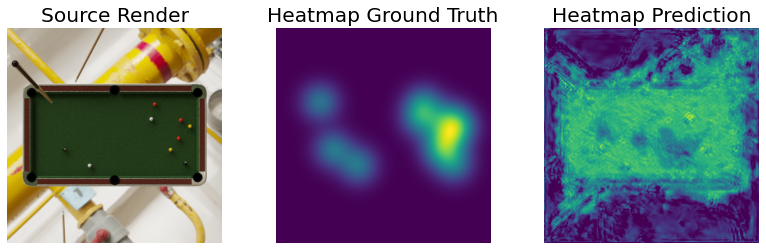

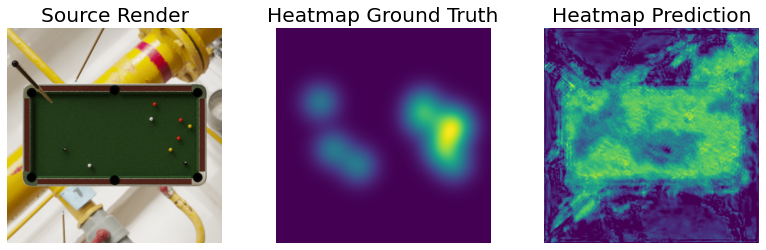

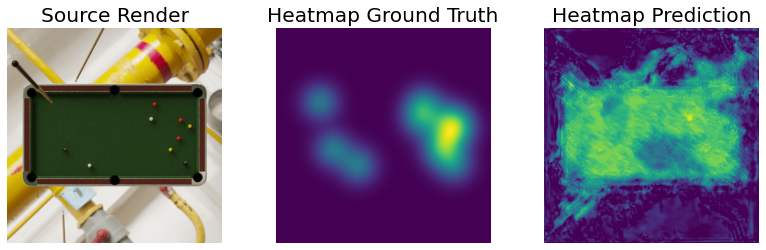

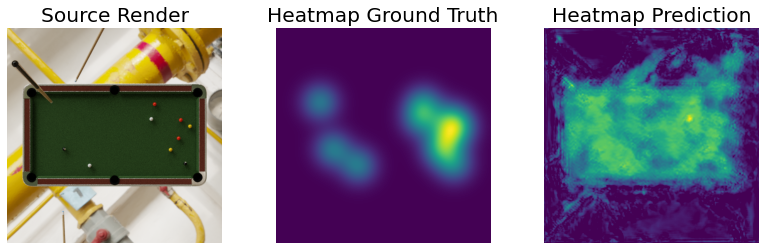

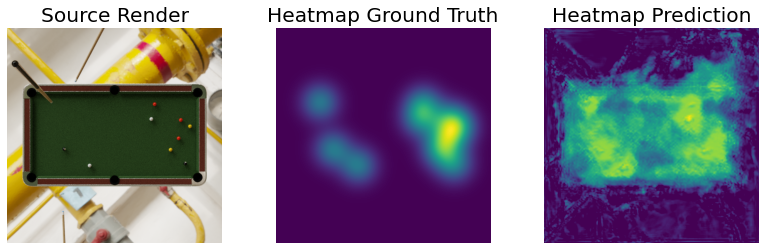

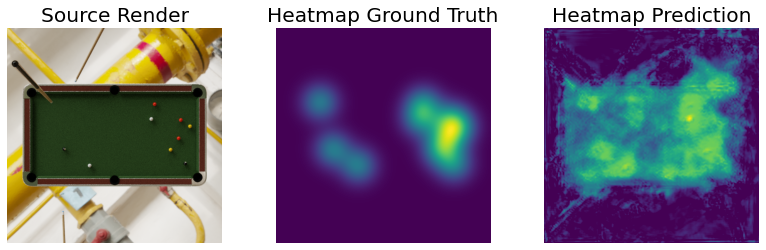

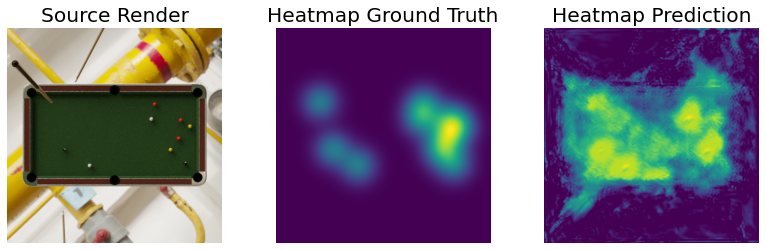

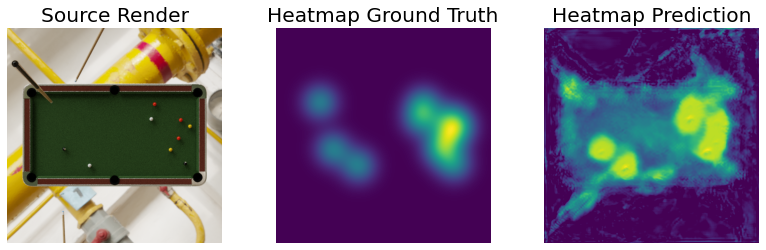

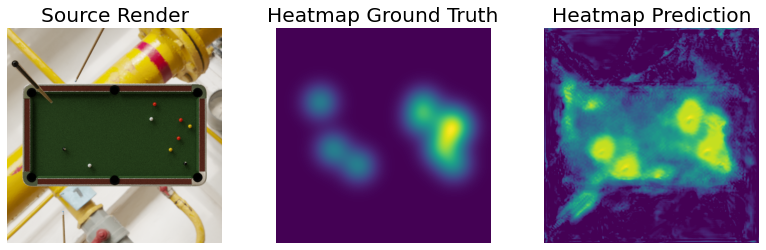

KeyboardInterrupt: 

In [10]:
history = {"train": [], "valid": []}
for epoch in tqdm(range(EPOCHS + REFINE), desc="Epoch"):
    t      = min(epoch, EPOCHS) / EPOCHS
    spread = max(SPREAD) - t * abs(np.subtract(*SPREAD))
    
    train_loader.dataset.spread = spread
    valid_loader.dataset.spread = spread 
    
    history["train"].append(step("Train", train_loader, spread, is_train=True))
    
    with torch.no_grad(): 
        history["valid"].append(step("Valid", valid_loader, spread, is_train=False))
        plot_example(valid)
        
with torch.no_grad():
    step("Test", test_loader, spread, is_train=False)
    plot_example(test)   
    
plot_loss_history(history["train"], history["valid"])